# Renewable energy production in Germany
## data loading, exploration and enrichment
First I import the necessary libraries and load the data. I have downloaded the energy generation data by energy type from the official site of the German Federal Network Agency here: www.smard.de. The data is provided with a resolutio of 15 minutes, i.e. there is a record for every 15 minutes. It is possible to select a maximum of two years of data. Since I want to use four years of data for training and testing, I have downloaded two times two years of data, so that my first record is on January 15th of 2018 and the last on January 15th of 2022. 

In [1]:
import pandas as pd
import os
# the weather data
import meteostat

#for visualisations
from matplotlib import pyplot as plt

#for data quality checking
from datetime import date

In [2]:
# set the data source path and files variables
data_path = '/home/olga/Downloads/'
file1 = 'Realisierte_Erzeugung_202001150000_202201152359.csv' 
file2 = 'Realisierte_Erzeugung_201801150000_202001142359.csv'

In [5]:
# merge the two csv files
df1 = pd.read_csv(os.path.join(data_path, file1), sep=';')
df2 = pd.read_csv(os.path.join(data_path, file2), sep=';')
df = pd.concat([df2, df1], ignore_index=True)

/home/olga/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# get first impression of the data
df.head(10)

,Datum,Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Pumpspeicher[MWh],Sonstige Konventionelle[MWh]
0,15.01.2018,00:00,"1.210,5","433,25",711.0,3.926,0.0,58,"2.267,5",4.149,939.0,1.127,191.0,289.0
1,15.01.2018,00:15,"1.210,25","433,5",768.0,3.965,0.0,58,"2.266,25",4.102,932.0,1.087,11.0,288.0
2,15.01.2018,00:30,"1.210,25",426,782.0,3.973,0.0,58,"2.262,75",4.083,927.0,1.077,171.0,288.0
3,15.01.2018,00:45,1.212,"422,25",772.0,4.015,0.0,58,"2.258,25",4.071,926.0,1.073,15.0,290.0
4,15.01.2018,01:00,"1.209,25",423,768.0,4.027,0.0,58,"2.267,75",4.079,900.0,1.075,191.0,288.0
5,15.01.2018,01:15,"1.208,5","421,25",836.0,4.095,0.0,58,"2.265,25",4.060,892.0,1.073,172.0,288.0
6,15.01.2018,01:30,"1.210,25","420,25",876.0,4.124,0.0,58,"2.262,5",4.035,876.0,1.071,168.0,288.0
7,15.01.2018,01:45,1.210,418,874.0,4.152,0.0,58,"2.257,25",4.006,872.0,1.072,155.0,288.0
8,15.01.2018,02:00,"1.209,25",424,863.0,4.143,0.0,58,"2.256,25",4.014,875.0,1.066,15.0,289.0
9,15.01.2018,02:15,"1.209,75",436,869.0,4.139,0.0,58,"2.250,25",3.990,866.0,1.064,11.0,290.0


In [7]:
df.tail()

,Datum,Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Pumpspeicher[MWh],Sonstige Konventionelle[MWh]
140347,15.01.2022,22:45,1.132,311,715.0,1.011,0.0,52,1.006,3.316,2.910,2.092,57.0,387.0
140348,15.01.2022,23:00,1.132,320,742.0,983.000,0.0,52,1.006,3.299,2.863,1.933,170.0,382.0
140349,15.01.2022,23:15,1.132,315,759.0,957.000,0.0,52,1.006,3.265,2.842,1.794,229.0,381.0
140350,15.01.2022,23:30,1.131,314,770.0,955.000,0.0,52,1.006,3.264,2.861,1.700,157.0,382.0
140351,15.01.2022,23:45,1.13,313,803.0,966.000,0.0,52,1.005,3.256,2.859,1.597,100.0,381.0


In the energy production data is one column for the date (Datum) and one column for the time (Uhrzeit) and there is a data point for every 15 minutes. When reading in the data I will convert these two colunms to one containing the datetime with the option parse_dates=[['Datum', 'Uhrzeit']].
And also the numerical columns seem to be formatted as usual in Germany: a dot is used to make the thousands more readable, i.e. the entry 1.132 means one 'thousand one hundred thirty two' and not 'one point one three two'. (see the graphics on www.smard.de for comparison of the scales). Check, if pandas interprets the dots as a decimal separator.  

In [8]:
df['sumWasserkraft'] = df[['Wind Offshore[MWh]', 'Wind Onshore[MWh]']].sum(axis=1)
df[['Wind Offshore[MWh]', 'Wind Onshore[MWh]', 'sumWasserkraft']].head()

,Wind Offshore[MWh],Wind Onshore[MWh],sumWasserkraft
0,711.0,3.926,714.926
1,768.0,3.965,771.965
2,782.0,3.973,785.973
3,772.0,4.015,776.015
4,768.0,4.027,772.027


Yes, the dot is interpreted by Pandas as a decimal separator (and for the 'Wind Offshore[MWh]' it actually is correctly a decimal separator, whereas for the 'Wind Onshore[MWh]' it is not. To correct this I need to reload the data and specify the option thousands='.' in read_csv(), so that the numbers will be interpreted correctly. 
Since the date column ('Datum') is formatted in the German date format, also containing a dot between day, month and year respectively, I need to use the converters option for read_csv(). See also here: https://stackoverflow.com/questions/62872697/how-to-open-a-german-csv-file-with-pandas.  

In [3]:
# write a function that reads in the renewable energy generation data for Germany 

def load_data(datapath, files, usecols):
    ''' This function takes as arguments the data files. This function reads in the data from multiple
        files (taking care of the German formats for the date and numerical variables) and appends 
        the data sets into one dataframe.'''
    
    # for handling the German date format define converters for read_csv
    converters = {'Datum': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}

    df = pd.DataFrame()
    for file in files:
        print('reading in data:', file)
        df = df.append(pd.read_csv(os.path.join(datapath, file), sep=';', thousands='.', decimal=',', 
                    converters=converters, usecols=usecols, parse_dates=[['Datum', 'Uhrzeit']]), 
                    ignore_index=True)
        print('the shape of the dataframe is:', df.shape)
    
    print('Loading process finished.')
    return df
    

In [4]:
files = [file2, file1]
# I only need the renewables and the date and time fields 
renewables = ['Biomasse[MWh]', 'Wasserkraft[MWh]', 'Wind Offshore[MWh]', 'Wind Onshore[MWh]', 'Photovoltaik[MWh]', 'Sonstige Erneuerbare[MWh]']
df = load_data(datapath=data_path, files=files, usecols=['Datum', 'Uhrzeit']+renewables)

reading in data: Realisierte_Erzeugung_201801150000_202001142359.csv
the shape of the dataframe is: (70080, 7)
reading in data: Realisierte_Erzeugung_202001150000_202201152359.csv
the shape of the dataframe is: (140352, 7)
Loading process finished.


In [5]:
# check if the loaded data looks ok
df.head()

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
0,2018-01-15 00:00:00,1210.50,433.25,711,3926,0,58
1,2018-01-15 00:15:00,1210.25,433.50,768,3965,0,58
2,2018-01-15 00:30:00,1210.25,426.00,782,3973,0,58
3,2018-01-15 00:45:00,1212.00,422.25,772,4015,0,58
4,2018-01-15 01:00:00,1209.25,423.00,768,4027,0,58


In [6]:
df.tail()

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
140347,2022-01-15 22:45:00,1132.0,311.0,715,1011,0,52
140348,2022-01-15 23:00:00,1132.0,320.0,742,983,0,52
140349,2022-01-15 23:15:00,1132.0,315.0,759,957,0,52
140350,2022-01-15 23:30:00,1131.0,314.0,770,955,0,52
140351,2022-01-15 23:45:00,1130.0,313.0,803,966,0,52


## Data Exploration
Now that the data is loaded in the correct format, I want to validate its quality. First I check, if there are missing values.

In [7]:
#check if there are null values
for source in renewables:
    print('number of null values for ' + source + ':' + str(df[source].isnull().sum()))

number of null values for Biomasse[MWh]:0
number of null values for Wasserkraft[MWh]:0
number of null values for Wind Offshore[MWh]:0
number of null values for Wind Onshore[MWh]:0
number of null values for Photovoltaik[MWh]:0
number of null values for Sonstige Erneuerbare[MWh]:0


Very good, there are no missing values!

In [8]:
# check the statistics for the columns
df.describe()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
count,140352.000000,140352.000000,140352.000000,140352.000000,140352.000000,140352.000000
mean,1144.762305,434.845661,676.311125,2724.629973,1251.938490,43.802340
std,61.866552,91.059819,464.799092,2166.711707,1920.952892,8.120243
min,925.750000,217.000000,0.000000,24.000000,0.000000,28.000000
25%,1098.000000,362.000000,248.000000,1059.000000,0.000000,37.000000
50%,1145.000000,429.500000,635.000000,2076.000000,22.000000,43.000000
75%,1201.500000,506.250000,1060.000000,3833.000000,2019.000000,51.000000
max,1264.000000,741.250000,1816.000000,10580.000000,9096.000000,62.000000


Seems reasonable. Wind Onshore has the bigges standard deviation, next solar. It is know that the wind onshore is very volatile and the sun power generation is always 0 at night and is sometimes really high around noon. Also that the Wind Onshore contributes most to the renewable power generation is plausible. Only why the minimum for Wind Offshore is 0?

In [9]:
# find the data points where the wind offshore is 0
df.loc[df['Wind Offshore[MWh]'] == 0]

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
52651,2019-07-17 11:45:00,1104.0,491.0,0,119,5651,36
52652,2019-07-17 12:00:00,1100.0,534.0,0,119,5807,35
52655,2019-07-17 12:45:00,1097.0,484.0,0,137,5965,35
52656,2019-07-17 13:00:00,1088.0,543.0,0,151,5997,35
52658,2019-07-17 13:30:00,1088.0,535.0,0,172,5902,35
...,...,...,...,...,...,...,...
138654,2021-12-29 07:30:00,1088.0,346.0,0,3143,0,44
138657,2021-12-29 08:15:00,1096.0,344.0,0,2985,6,51
138658,2021-12-29 08:30:00,1096.0,345.0,0,2925,30,52
138659,2021-12-29 08:45:00,1095.0,336.0,0,2872,72,52


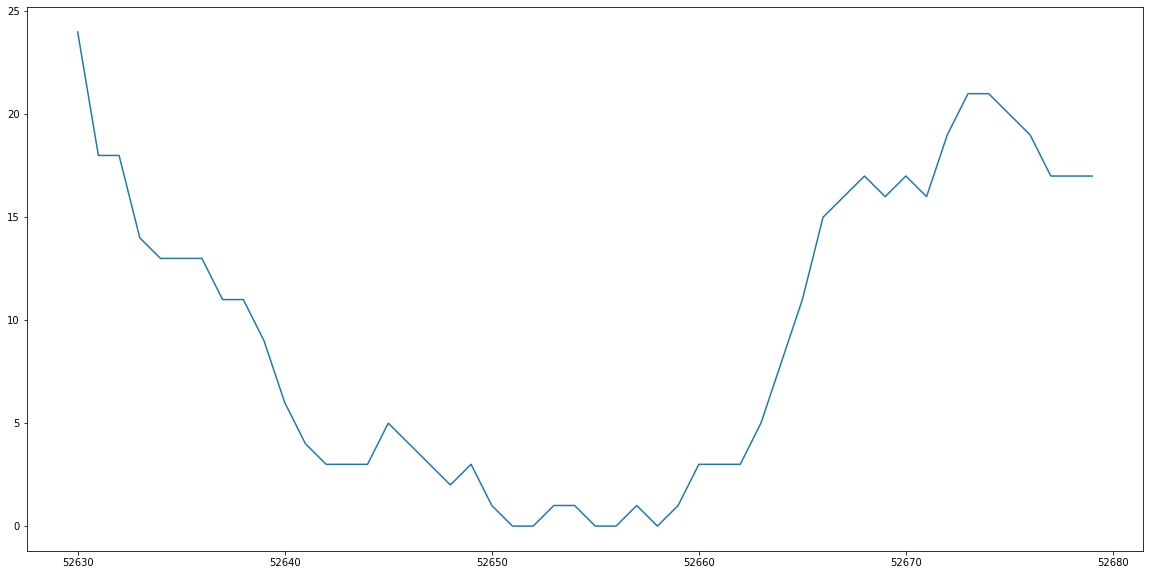

In [64]:
# plot the time-series around that point 
plt.rcParams['figure.figsize'] = [20, 10]
df['Wind Offshore[MWh]'].iloc[52630:52680].plot()
plt.show()

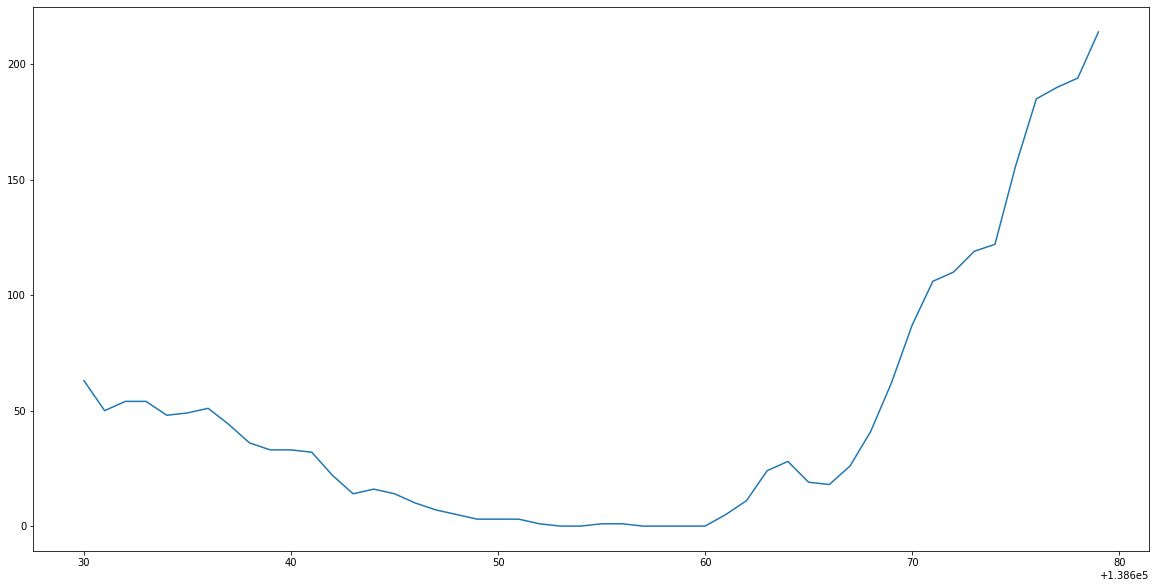

In [62]:
plt.rcParams['figure.figsize'] = [20, 10]
df['Wind Offshore[MWh]'].iloc[138630:138680].plot()
plt.show()

seems like there is just little wind or wind power production was turned off during that time and not a data issue.

#### note to self: review!
Since I want to analyze the total amount of the reneable energy, I only need to look at the sum. And also, I want to forecast hourly power generation, so I will downsample to hourly values (the dataframe now contains the power generation for every 15 minutes). What makes more sense: average for that hour or sum? If I chose the average, then the hourly data will contain the average renewable power generation for every hour/during every hour. The numbers will be on the same scale as for the original data, but some extreme points will be flattened to the mean. If I chose the sum, I will have the cumulative power generation for every hour, i.e. for every hour the absolute amount of energy that was generated during that hour. I want to use sum.

In [10]:
# sum the individual renewable sources into the total renewable generation
df['total renewables[MWh]'] = df[renewables].sum(axis=1)
df_renew = df[['Datum_Uhrzeit', 'total renewables[MWh]']]

In [11]:
df_renew.head(10)

,Datum_Uhrzeit,total renewables[MWh]
0,2018-01-15 00:00:00,6338.75
1,2018-01-15 00:15:00,6434.75
2,2018-01-15 00:30:00,6449.25
3,2018-01-15 00:45:00,6479.25
4,2018-01-15 01:00:00,6485.25
5,2018-01-15 01:15:00,6618.75
6,2018-01-15 01:30:00,6688.50
7,2018-01-15 01:45:00,6712.00
8,2018-01-15 02:00:00,6697.25
9,2018-01-15 02:15:00,6711.75


In [12]:
# set the timestamp as index
df_renew = df_renew.set_index('Datum_Uhrzeit')
df_renew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140352 entries, 2018-01-15 00:00:00 to 2022-01-15 23:45:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   total renewables[MWh]  140352 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [19]:
# downsample to hourly datapoints with 
# sum: total amount of energy produced during that hour
# mean: mean amount of energy produced during that hour at every time point
# because of troubles with daylight saving time take the mean
resample = df_renew.resample('H')
hourly_renew = resample.mean()
hourly_renew.head()

,total renewables[MWh]
Datum_Uhrzeit,
2018-01-15 00:00:00,6425.5000
2018-01-15 01:00:00,6626.1250
2018-01-15 02:00:00,6688.2500
2018-01-15 03:00:00,6787.1875
2018-01-15 04:00:00,7019.0625


Interpretation of this time-series: 
During the hour between 00:00 and 01:00 the renewable energy sources produced an average of 6425.5 MWh.


'During the hour between 00:00 and 01:00 25702 MWh renewable energy was produced in Germany, during the hour between 01:00 and 02:00 a total amount of 26504.5 MWh renewable energy was generated in Germany and so on.

In [20]:
hourly_renew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35088 entries, 2018-01-15 00:00:00 to 2022-01-15 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total renewables[MWh]  35084 non-null  float64
dtypes: float64(1)
memory usage: 548.2 KB


In [21]:
hourly_renew.describe()

,total renewables[MWh]
count,35084.000000
mean,6276.167299
std,2806.152487
min,1620.250000
25%,3979.437500
50%,5840.250000
75%,8176.000000
max,16839.250000


Now we have a count of 35084 non-null values, but in the total amount of values is 35088. What are the null values? where do these come from?

In [39]:
# check when values are missing
hourly_renew.loc[hourly_renew.isnull()]

ValueError: Cannot index with multidimensional key

ok, it's missing, which also kind of makes sense, because there is no value. For fbprophet it's no problem, if a value is missing (see here: https://github.com/facebook/prophet/issues/854)

# visualize the time series

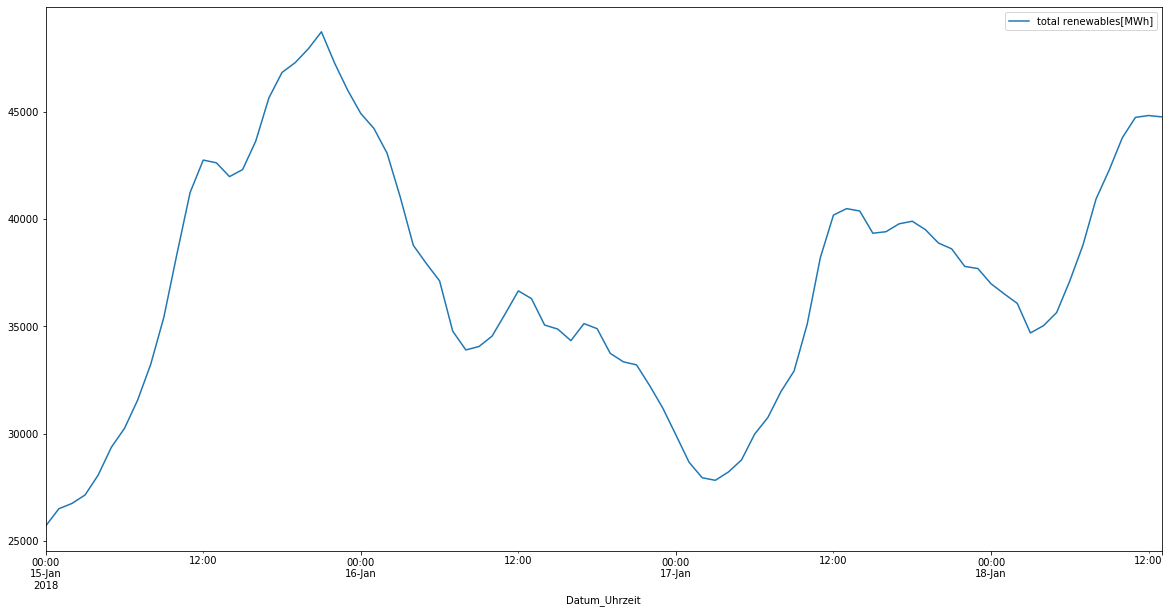

In [76]:
# make the intervals shorter for plotting
hourly_sum_power.iloc[0:86].plot()

## weather data from meteostat

# down here: archive 

In [32]:
# downsample to hourly datapoints with 
# sum: total amount of energy produced during that hour
# mean: mean amount of energy produced during that hour at every time point
# because of troubles with daylight saving time take the mean
resample = df_renew.resample('H')
hourly_renew = resample.sum()
hourly_renew.head()

,total renewables[MWh]
Datum_Uhrzeit,
2018-01-15 00:00:00,25702.00
2018-01-15 01:00:00,26504.50
2018-01-15 02:00:00,26753.00
2018-01-15 03:00:00,27148.75
2018-01-15 04:00:00,28076.25


In [33]:
hourly_renew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35088 entries, 2018-01-15 00:00:00 to 2022-01-15 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total renewables[MWh]  35088 non-null  float64
dtypes: float64(1)
memory usage: 548.2 KB


In [34]:
hourly_renew.describe()

,total renewables[MWh]
count,35088.000000
mean,25105.159577
std,11233.799420
min,0.000000
25%,15913.812500
50%,23358.000000
75%,32704.250000
max,75961.000000


The mean hourly renewable power generation is about 25,105 MWh in Germany and it is very volatile, because the standard deviation is high, about 11,233! Why is the minimum 0? Is it possible?

In [40]:
# when is it 0?
hourly_renew.loc[hourly_renew['total renewables[MWh]'] == 0]

,total renewables[MWh]
Datum_Uhrzeit,
2018-03-25 02:00:00,0.0
2019-03-31 02:00:00,0.0
2020-03-29 02:00:00,0.0
2021-03-28 02:00:00,0.0


Ok, it is only 0 during the hour between 2 a.m. and 3 a.m. at the end of March every year. This is the European time shift from winter to summer time. Every last sunday in March the hour between 2 and 3 a.m. is skipped, i.e. it actually does not exist. So I will drop these raws. And also every last Sunday in October the hour between 2 and 3 am is repeated, when the time shifts from summer to winter time. How is this reflected in the time-series?

In [41]:
# see what value is in the original data
df.head(6633)

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],total renewables[MWh]
0,2018-01-15 00:00:00,1210.50,433.25,711,3926,0,58,6338.75
1,2018-01-15 00:15:00,1210.25,433.50,768,3965,0,58,6434.75
2,2018-01-15 00:30:00,1210.25,426.00,782,3973,0,58,6449.25
3,2018-01-15 00:45:00,1212.00,422.25,772,4015,0,58,6479.25
4,2018-01-15 01:00:00,1209.25,423.00,768,4027,0,58,6485.25
...,...,...,...,...,...,...,...,...
6628,2018-03-25 01:00:00,1096.25,323.75,36,505,0,57,2018.00
6629,2018-03-25 01:15:00,1095.50,324.50,32,493,0,57,2002.00
6630,2018-03-25 01:30:00,1091.75,324.00,30,470,0,57,1972.75
6631,2018-03-25 01:45:00,1089.75,323.25,26,457,0,57,1953.00


--> There is no data point for 2 a.m.! And it is filled with a 0 for the sum!

--> in the original data it is repeated and in the aggregation it is added for the hour 2 a.m.


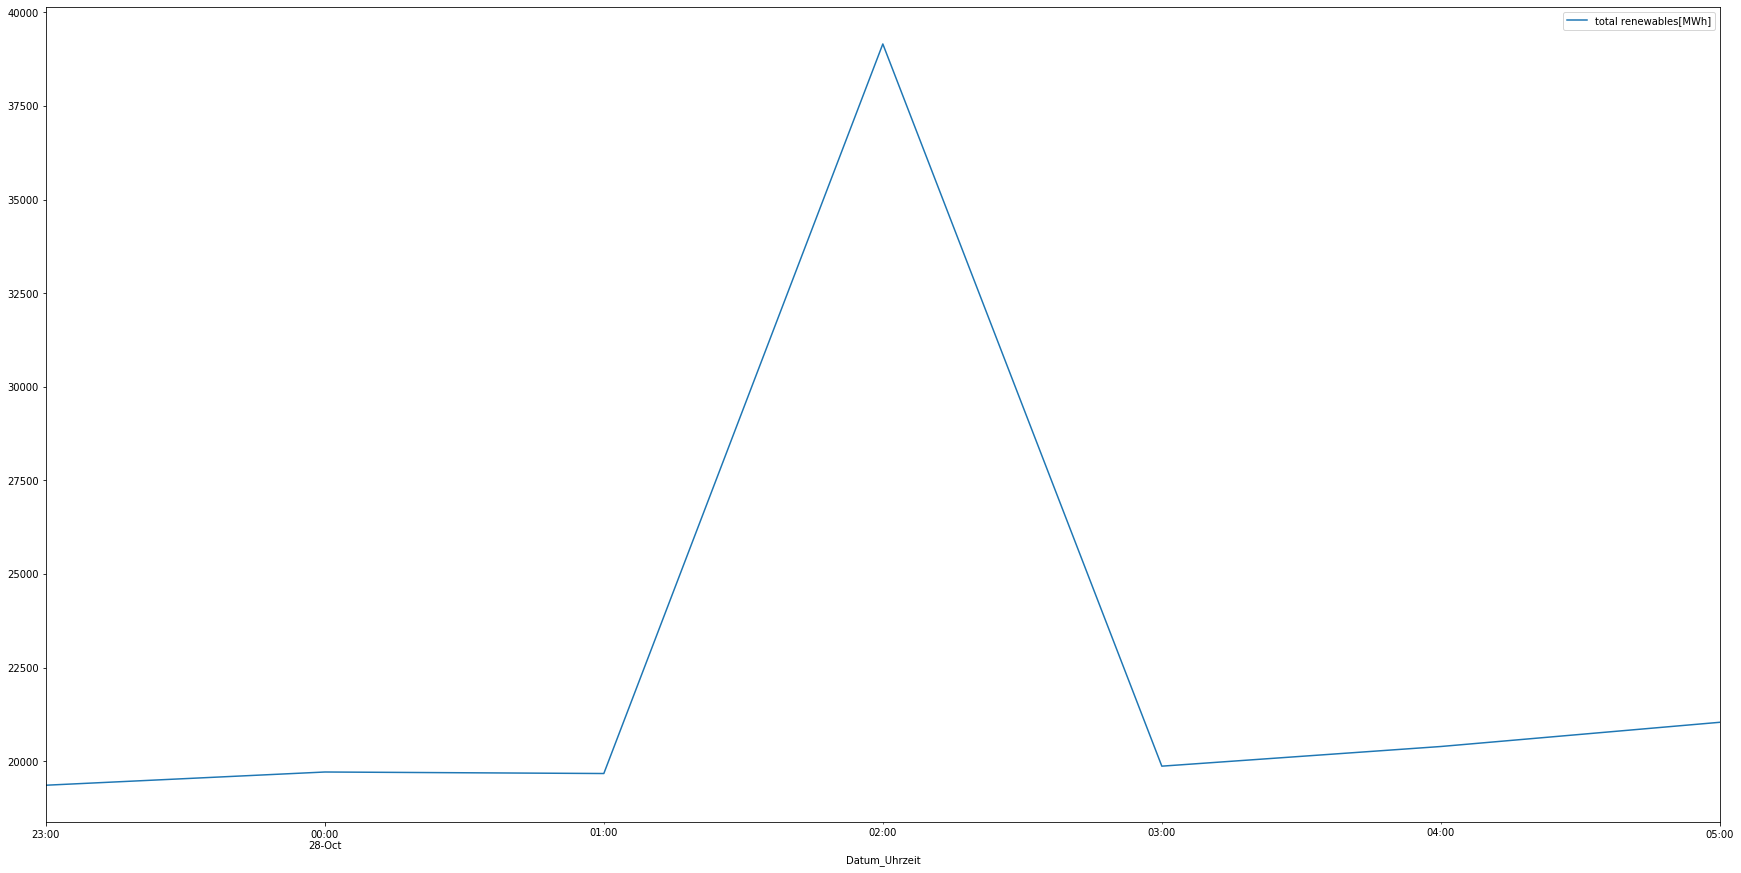

In [42]:
# October 28 in 2018 was the time shift, find that date and plot it
hourly_renew.iloc[6863:6870].plot()

In [43]:
# see the values around the time shift in the original data
df.head(27466)

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],total renewables[MWh]
0,2018-01-15 00:00:00,1210.50,433.25,711,3926,0,58,6338.75
1,2018-01-15 00:15:00,1210.25,433.50,768,3965,0,58,6434.75
2,2018-01-15 00:30:00,1210.25,426.00,782,3973,0,58,6449.25
3,2018-01-15 00:45:00,1212.00,422.25,772,4015,0,58,6479.25
4,2018-01-15 01:00:00,1209.25,423.00,768,4027,0,58,6485.25
...,...,...,...,...,...,...,...,...
27461,2018-10-28 02:15:00,1175.25,309.00,628,2699,0,37,4848.25
27462,2018-10-28 02:30:00,1174.00,308.75,611,2734,0,37,4864.75
27463,2018-10-28 02:45:00,1173.00,308.00,604,2761,0,37,4883.00
27464,2018-10-28 02:00:00,1175.50,307.50,578,2774,0,37,4872.00


In [ ]:
# define the datetimes when the time shift took place
time_shifts = ['2018-10-28 02:00', '2019-10-27 02:00', '2020-10-25', '2021-10-31 02:00']

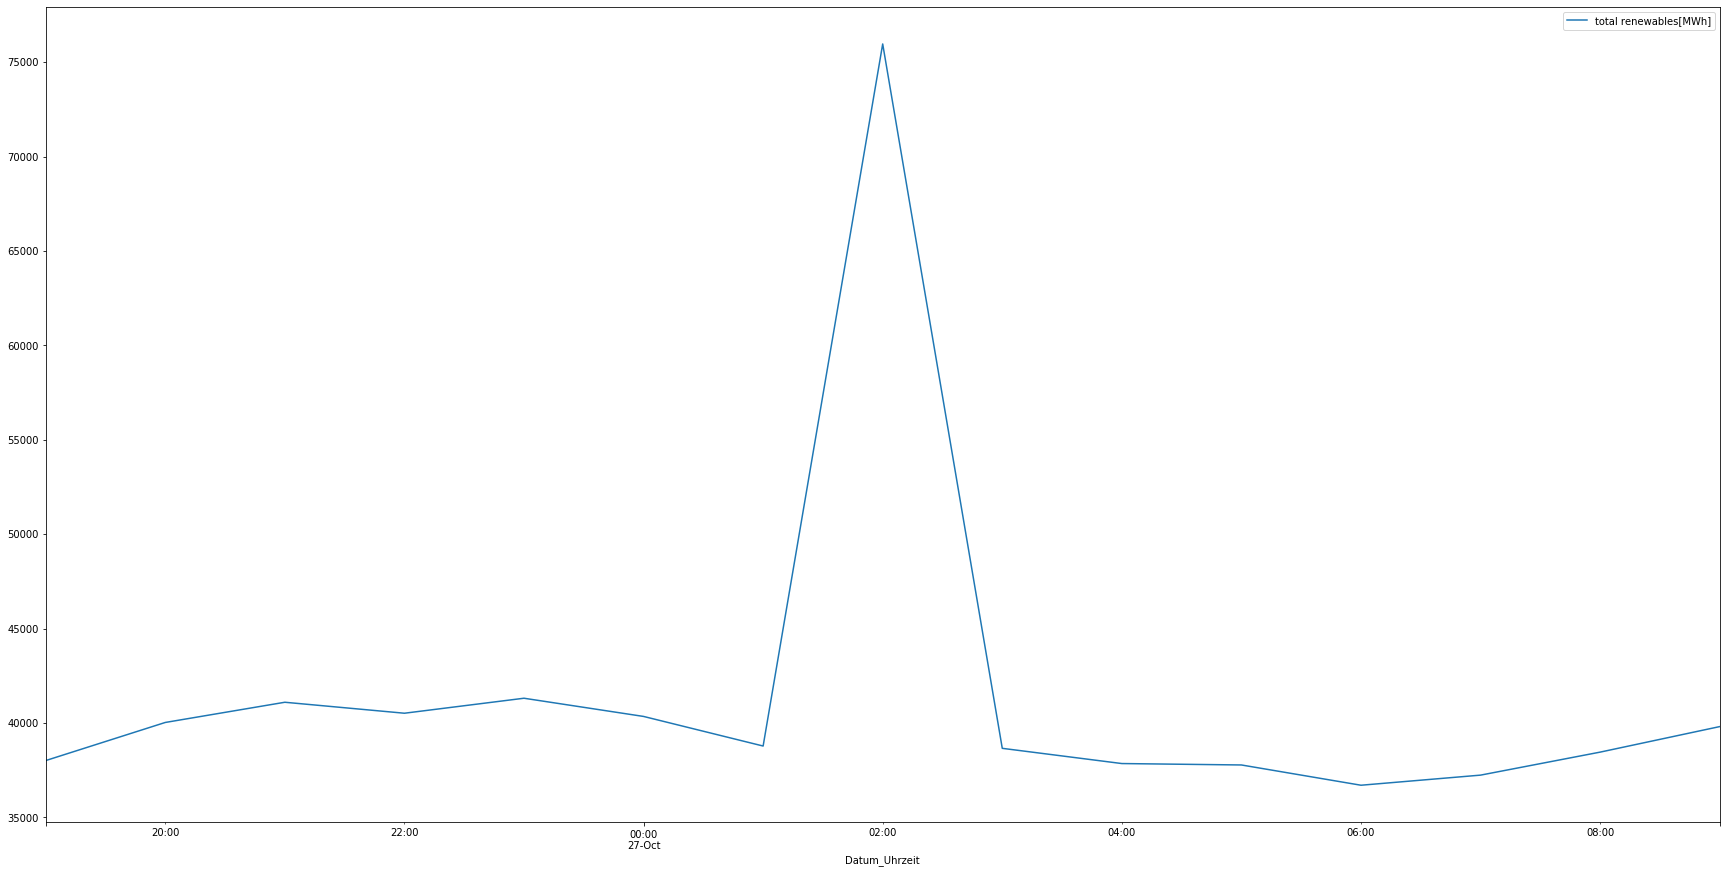

In [44]:
# print the time-series renewable power generation around the time shift
plt.rcParams['figure.figsize'] = [30, 15]
hourly_renew.iloc[15595:15610].plot()
plt.show()

In [ ]:
# proper DatetimeIndex --> does not work!
# if time shifts from winter to summer time, the hour is missing and the sum of 0 is not necessary, 
# hence, the hour in the aggregated time series should also be missing, that's as in the reality
# it time shifts from summer to winter time, the hour is there twice and should also be there twice
# in the aggregated time series as in reality
# how to accomplish this?
# for the missing hour is clear, just drop the 0 value for that hour!
# for the double hour: actually need to have the hour twice and sum for the first and second hour separately
# an approximate solution would be to add a data point and take the average for both 
# or just leave all as is? just be aware that the forecast is actually for two hours?
# or use mean to aggregate instead of sum? then we do not have any problem? for the missing hour it's 0, but 
# the hour is missing anyway and for the double hour it's a quite good approximation

#df = df.set_index('Datum_Uhrzeit')
#df.index = pd.to_datetime(df.index, utc=True)

In [46]:
df.head(27466)

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],total renewables[MWh]
0,2018-01-15 00:00:00,1210.50,433.25,711,3926,0,58,6338.75
1,2018-01-15 00:15:00,1210.25,433.50,768,3965,0,58,6434.75
2,2018-01-15 00:30:00,1210.25,426.00,782,3973,0,58,6449.25
3,2018-01-15 00:45:00,1212.00,422.25,772,4015,0,58,6479.25
4,2018-01-15 01:00:00,1209.25,423.00,768,4027,0,58,6485.25
...,...,...,...,...,...,...,...,...
27461,2018-10-28 02:15:00,1175.25,309.00,628,2699,0,37,4848.25
27462,2018-10-28 02:30:00,1174.00,308.75,611,2734,0,37,4864.75
27463,2018-10-28 02:45:00,1173.00,308.00,604,2761,0,37,4883.00
27464,2018-10-28 02:00:00,1175.50,307.50,578,2774,0,37,4872.00
